In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.integrate import solve_ivp
import utils
%load_ext autoreload
%autoreload 2

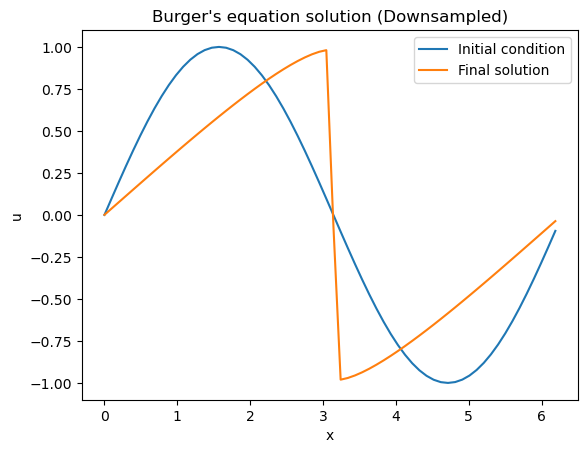

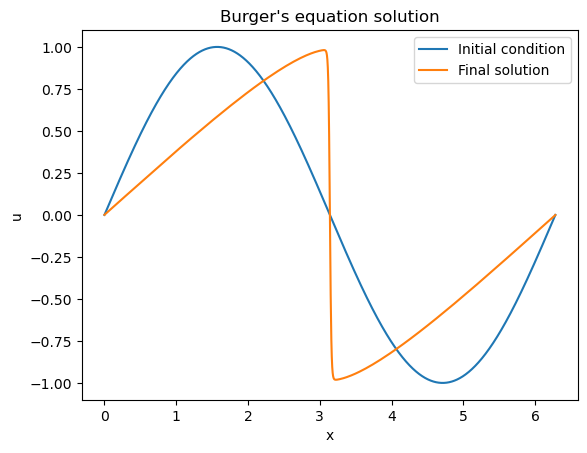

In [2]:

# Parameters
L = 2*np.pi  # Spatial domain length
T = 1.6037  # Time domain length
nu = 0.01  # Viscosity coefficient
N = 2**11  # Number of grid points
dt = 0.001  # Time step
dx = L / N   # Spatial step

# Initialize grid
x = np.linspace(0, L, N)
u0 = -np.sin(x-np.pi)  # Initial condition
u = u0.copy()


kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Define the KdV equation
def rhsBurgers(t,u,kappa,nu): 
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    dd_uhat = -np.power(kappa,2)*uhat
    d_u = np.fft.ifft(d_uhat)
    dd_u = np.fft.ifft(dd_uhat)
    du_dt = -u * d_u + nu*dd_u
    return du_dt.real

# Solve Burger's equation using odeint
t = np.linspace(0,T,500)

sol =  solve_ivp(rhsBurgers, [t[0], t[-1]], u0, t_eval=t, args=(kappa,nu))
u = sol.y.T
# Plot results
space_res = 64  # Desired spatial resolution

# Downsample the solution
downsampled_u = u[:, ::N//space_res]

plt.plot(x[::N//space_res], u0[::N//space_res], label='Initial condition')
plt.plot(x[::N//space_res], downsampled_u[-1,:], label='Final solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title("Burger's equation solution (Downsampled)")
plt.legend()
plt.show()

    
# Plot results
plt.plot(x, u0, label='Initial condition')
plt.plot(x, u[-1,:], label='Final solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title("Burger's equation solution")
plt.legend()
plt.show()

In [21]:

x_grid,t_points,u_initial,u_solution = utils.burgers_equation_simulation2(u0, x, dt, T, nu,64,64,keep_first_t=False,solver='Fourier')



In [22]:
u_t_train = np.zeros((1,u_solution.shape[1],u_solution.shape[0]))
u_0_train = np.zeros((1,u_solution.shape[1],u_solution.shape[0]))
u_t_train[0] = (u_solution.T)[None,:]
u_0_train[0] = np.tile(u_initial, (len(t_points), 1))

In [23]:
import torch
import utils
import os
import torch
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.datasets.transforms import PositionalEmbedding2D
from neuralop.datasets.data_transforms import DefaultDataProcessor
from neuralop.models import TFNO

from matplotlib import pyplot as plt
import numpy as np
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
initial_conditions = {
    'u_initial_1': utils.u_initial_1,
    'u_initial_2': utils.u_initial_2,
    'u_initial_3': utils.u_initial_3,
    'u_initial_4': utils.u_initial_4,
    'u_initial_5': utils.u_initial_5,
    'u_initial_6': utils.u_initial_6,
    'u_initial_7': utils.u_initial_7,
    'u_initial_8': utils.u_initial_8,
}

# Specify the directory
directory = 'models/fourier_solver_1000_128_64'

# Load the model
model_path = os.path.join(directory, 'model_full.pth')
model = torch.load(model_path,map_location=device)


# Downsample the training data
X = torch.tensor(u_0_train, dtype=torch.float32).to(device)
y = torch.tensor(u_t_train, dtype=torch.float32).to(device)
X = X.unsqueeze(1)
y = y.unsqueeze(1)

train_db = TensorDataset(X,y)

train_loader = torch.utils.data.DataLoader(
    train_db,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=False if device == 'cuda' else True,
    persistent_workers=False,
)

reduce_dims = list(range(X.ndim))
#input_encoder = UnitGaussianNormalizer(dim=reduce_dims)
#input_encoder.fit(X)
pos_encoding = PositionalEmbedding2D(grid_boundaries=[[0,T],[0,L]])


# if encoding == "channel-wise":
#     reduce_dims = list(range(y_train.ndim))
# elif encoding == "pixel-wise":
#     reduce_dims = [0]

# output_encoder = UnitGaussianNormalizer(dim=reduce_dims)
# output_encoder.fit(y_train)

data_processor = DefaultDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    positional_encoding=pos_encoding
)
data_processor = data_processor.to(device)

In [24]:
train_loader.dataset[0]['x'].shape

torch.Size([1, 64, 64])

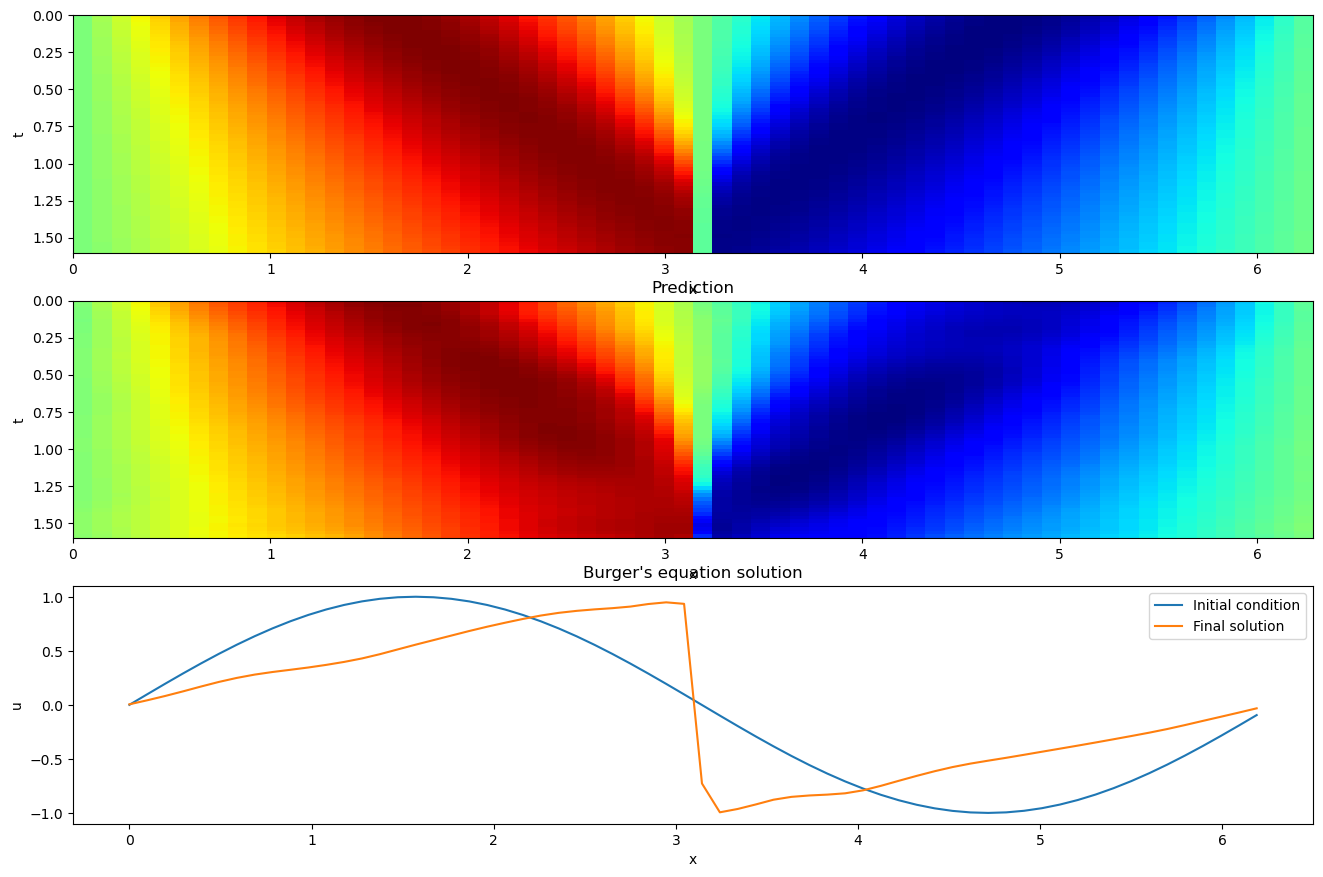

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10.5))
i = 0
sample = train_loader.dataset[0]
u_0 = sample['x'].detach().cpu().numpy()
u_t = sample['y'].detach().cpu().numpy()
#u_t_pred = model(data_processor(sample['x'])).detach().cpu().numpy()
u_initial = u_0[0][0]
# Plot the data in the corresponding subplot
axs[i].imshow(u_t.squeeze(), aspect='auto',extent=[0,L,T,0], cmap='jet')

axs[i].set_xlabel('x')
axs[i].set_ylabel('t')
i = 1

data_processor.preprocess(sample, batched=False)['x']
pred = model(sample['x'].unsqueeze(0)).squeeze().detach().cpu().numpy()
axs[i].imshow(pred, aspect='auto',extent=[0,L,T,0], cmap='jet')
axs[i].set_title(f'Prediction')
axs[i].set_xlabel('x')
axs[i].set_ylabel('t')
i = 2

# Plot results
axs[i].plot(x_grid, u_initial, label='Initial condition')
axs[i].plot(x_grid, pred[-1,:], label='Final solution')
axs[i].set_xlabel('x')
axs[i].set_ylabel('u')
axs[i].set_title("Burger's equation solution")
axs[i].legend()

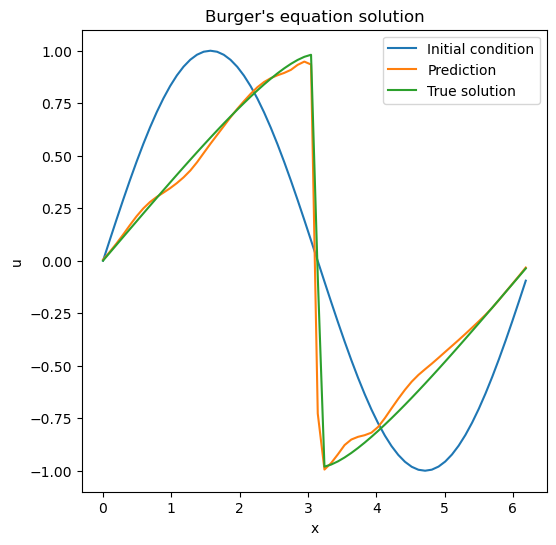

In [26]:

# Plot results
plt.figure(figsize=(6, 6))
plt.plot(x_grid, u_initial, label='Initial condition')
plt.plot(x_grid, pred[-1,:], label='Prediction')
plt.plot(x_grid, u_solution[:,-1], label='True solution')

plt.xlabel('x')
plt.ylabel('u')
plt.title("Burger's equation solution")
plt.legend()